### homework6:使用matlab或python实现维纳滤波，要求：比较信噪比未知，信噪比已知，图像和噪声自相关函数已知，这三种情况下的图像复原结果。

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
from scipy.signal import wiener


In [3]:
# 仿真运动模糊
def motion(sz, motion_angle):
    PSF = np.zeros(sz)
    center_position = (sz[0] - 1) / 2  #找到全0矩阵的中心行数center_position
    motion_tan = math.tan(motion_angle * math.pi / 180)
    motion_cot = 1 / motion_tan
    if motion_tan <= 1: #α≤45°时，PSF[int(center_position+offset),int(center_position-offset)]=1
        for i in range(15):
            offset = round(i * motion_tan)  # 运动的偏移量offset:((center_position-i)*motion_tan) 
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  # 对点扩散函数进行归一化亮度
    else:#α≥45°时，PSF[int(center_position-offset),int(center_position+offset)]=1
        for i in range(15):
            offset = round(i * motion_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()


# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

In [4]:
def wiener_filtering(g, h, K):
    g_fft = fft.fft2(g)
    h_fft = fft.fft2(h)
    h_fft_1 = np.conj(h_fft) / (np.abs(h_fft) ** 2 + K)
    result = fft.ifft2(g_fft * h_fft_1)
    result = np.abs(fft.fftshift(result))
    return result


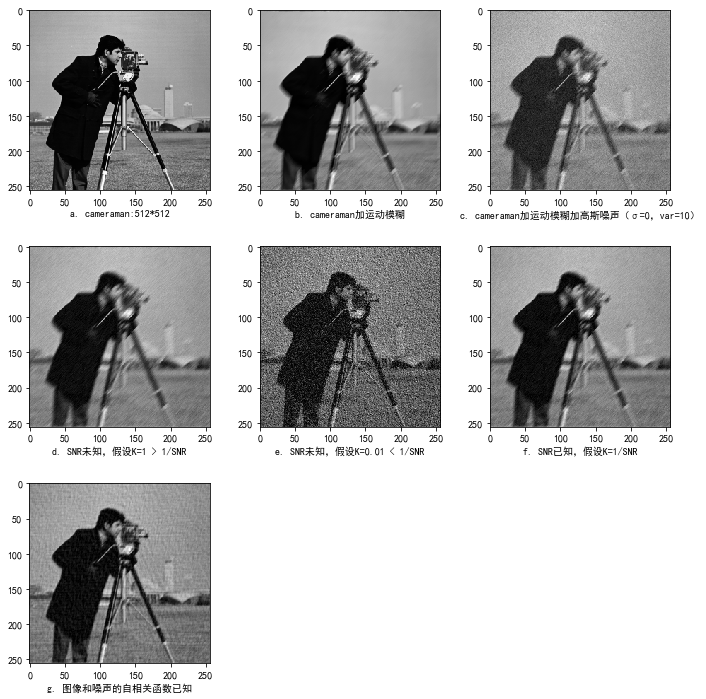

'\na 是干净的图f；b 是加运动模糊后的图；c 是运动模糊后再加gauss噪声的图；\nd SNR未知，即K未知,设K>1/SNR; e SNR未知，即K未知,设K<1/SNR; f SNR已知，即K已知,K=1/SNR; \ng 图像和噪声的自相关函数(功率谱）已知\n\nK=1/SNR的f 比 K>1/SNR的d 去模糊更好，可能是因为K>1/SNR，H起的作用小\nK=1/SNR的f 比 K<1/SNR的e 去噪声更好，e反而噪声放大了\n由图像和噪声的自相关函数得到的K，去模糊和噪声更好\n'

In [9]:
#g=hf+n：f是清晰图，h是退化函数，n是加性高斯噪声，g是退化图 
cameraman=cv2.imread('./cameraman.tif',0)
r,c=cameraman.shape
#加运动模糊：h
h = motion((r, c), 20)
cameraman_blurred = np.abs(make_blurred(cameraman, h, 1e-3))
#加均值为0，方差为1的高斯噪声
gauss=np.random.normal(0,100**0.5,(r,c))
#退化图
g_cameraman_blurred=cameraman_blurred+gauss

cameraman_fft = np.abs(fft.fft2(cameraman)) #原图自相关函数
gauss_fft = np.abs(fft.fft2(gauss)) #噪声自相关函数
#SNR未知，即K未知;估计SNR
K1_1=1
deg_cameraman1_1=wiener_filtering(g_cameraman_blurred, h, K1_1)
K1_2=0.01
deg_cameraman1_2=wiener_filtering(g_cameraman_blurred, h, K1_2)
#SNR已知，即K已知
SNR=sum(sum(cameraman_fft))/sum(sum(gauss_fft))
K2=1/SNR
deg_cameraman2=wiener_filtering(g_cameraman_blurred, h, K2)
#图像和噪声的自相关函数已知
K3=gauss_fft**2/cameraman_fft**2
deg_cameraman3=wiener_filtering(g_cameraman_blurred, h, K3)

plt.figure(figsize=(10, 10))
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.subplot(331), plt.imshow(cameraman, 'gray'),plt.xlabel('a. cameraman:512*512')
plt.subplot(332), plt.imshow(cameraman_blurred, 'gray'),plt.xlabel('b. cameraman加运动模糊')
plt.subplot(333), plt.imshow(g_cameraman_blurred, 'gray'),plt.xlabel('c. cameraman加运动模糊加高斯噪声（σ=0，var=10）')
plt.subplot(334), plt.imshow(deg_cameraman1_1, 'gray'),plt.xlabel('d. SNR未知，假设K=1 > 1/SNR')
plt.subplot(335), plt.imshow(deg_cameraman1_2, 'gray'),plt.xlabel('e. SNR未知，假设K=0.01 < 1/SNR')
plt.subplot(336), plt.imshow(deg_cameraman2, 'gray'),plt.xlabel('f. SNR已知，假设K=1/SNR')
plt.subplot(337), plt.imshow(deg_cameraman3, 'gray'),plt.xlabel('g. 图像和噪声的自相关函数已知')
plt.tight_layout()
plt.show()

'''
a 是干净的图f；b 是加运动模糊后的图；c 是运动模糊后再加gauss噪声的图；
d SNR未知，即K未知,设K>1/SNR; e SNR未知，即K未知,设K<1/SNR; f SNR已知，即K已知,K=1/SNR; 
g 图像和噪声的自相关函数(功率谱）已知

K=1/SNR的f 比 K>1/SNR的d 去模糊更好，可能是因为K>1/SNR，H起的作用小
K=1/SNR的f 比 K<1/SNR的e 去噪声更好，e反而噪声放大了
由图像和噪声的自相关函数得到的K，去模糊和噪声更好
'''